In [1]:
from pathlib import Path
import yaml

import numpy as np
import matplotlib.pyplot as plt

import openmdao.api as om

import flowers
import ard
import ard.wind_query as wq
import ard.layout.gridfarm as gridfarm
import ard.farm_aero.flowers as farmaero_flowers
import ard.farm_aero.floris as farmaero_floris

In [ ]:
# create the farm layout specification
farm_spec = {}
farm_spec["xD_farm"], farm_spec["yD_farm"] = [
    7 * v.flatten() for v in np.meshgrid(np.linspace(-2, 2, 2), np.linspace(-2, 2, 2))
]

# set up the modeling options
path_turbine = (
    Path(ard.__file__).parents[1]
    / "examples"
    / "data"
    / "windIO-plant_turbine_IEA-3.4MW-130m-RWT.yaml"
)
with open(path_turbine) as f_yaml:
    data_turbine_yaml = yaml.safe_load(f_yaml)
# set up the modeling options
path_wind_resource = Path.cwd() / "wind-resource.yaml"
with open(path_wind_resource) as f_yaml:
    data_wind_resource_yaml = yaml.safe_load(f_yaml)
modeling_options = modeling_options = {
    "windIO_plant": {
        "wind_farm": {
            "name": "unit test farm",
            "turbine": data_turbine_yaml,
            "layouts": {
                "coordinates": {
                    "x": farm_spec["xD_farm"] * data_turbine_yaml["rotor_diameter"],
                    "y": farm_spec["yD_farm"] * data_turbine_yaml["rotor_diameter"],
                }
            },
        },
        "site": {
            "energy_resource": {
                "wind_resource": data_wind_resource_yaml,
            },
        },
    },
    "layout": {
        "N_turbines": len(farm_spec["xD_farm"]),
        "spacing_primary": 7.0,
        "spacing_secondary": 5.0,
        "angle_orientation": 15.0,
        "angle_skew": 10.0,
    },
    # "floris": {
    #     # "peak_shaving_fraction": 0.4,
    #     # "peak_shaving_TI_threshold": 0.0,
    # },
    "wind_rose": {
        "windrose_resample": {
            "wd_step": 5.0,
            "ws_step": 1.0,
        },
    },
    "flowers": {
        "num_terms": 25,
        "k": 0.05,
        "windrose_resample": {
            "wd_step": 1.0,
            "ws_step": 0.5,
        },
    },
}

# create the OpenMDAO model
model = om.Group()
gf = model.add_subsystem(
    "gridfarm",
    gridfarm.GridFarmLayout(
        modeling_options=modeling_options,
    ),
    promotes=["*"],
)
model.add_subsystem(
    "batchFLOWERS",
    farmaero_flowers.FLOWERSAEP(
        modeling_options=modeling_options,
    ),
    promotes=["x_turbines", "y_turbines"],
)
model.add_subsystem(
    "batchFLORIS",
    farmaero_floris.FLORISAEP(
        modeling_options=modeling_options,
        case_title="FLOWERS_test",
    ),
    promotes=["x_turbines", "y_turbines"],
)

prob = om.Problem(model)
prob.setup()

prob.set_val(
    "x_turbines",
    modeling_options["windIO_plant"]["wind_farm"]["layouts"]["coordinates"]["x"],
    units="m",
)
prob.set_val(
    "y_turbines",
    modeling_options["windIO_plant"]["wind_farm"]["layouts"]["coordinates"]["y"],
    units="m",
)

/Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:328: RuntimeWarning: invalid value encountered in divide
  val = 2 * (avg_v - v_core) / (v_top + v_bottom)
/Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163: RuntimeWarning: invalid value encountered in divide
  C0 = 1 - u0 / freestream_velocity
/Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:498: RuntimeWarning: invalid value encountered in divide
  I_total = np.sqrt((2 / 3) * k_total) / average_u_i
/Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80: RuntimeWarning: invalid value encountered in divide
  sigma_z0 = rotor_diameter_i * 0.5 * np.sqrt(uR / (u_initial + u0))


angle_orientation_vec shape: (144,)
AEP_flowers_vec shape: (144,)
AEP_floris_vec shape: (144,)


/Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:328: RuntimeWarning: invalid value encountered in divide
  val = 2 * (avg_v - v_core) / (v_top + v_bottom)
/Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163: RuntimeWarning: invalid value encountered in divide
  C0 = 1 - u0 / freestream_velocity
/Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:498: RuntimeWarning: invalid value encountered in divide
  I_total = np.sqrt((2 / 3) * k_total) / average_u_i
/Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80: RuntimeWarning: invalid value encountered in divide
  sigma_z0 = rotor_diameter_i * 0.5 * np.sqrt(uR / (u_initial + u0))
/Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:328: RuntimeWarni

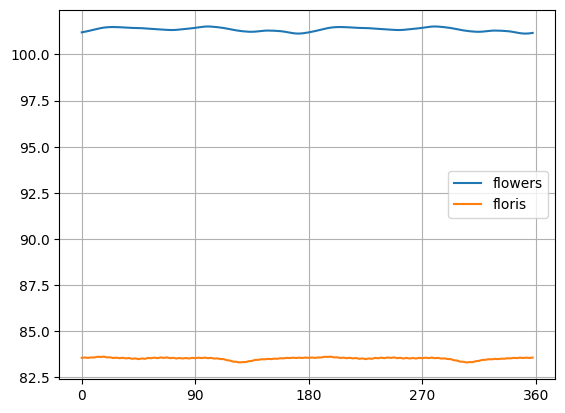

In [3]:
prob.run_model()

angle_orientation_vec = np.arange(0.0, 360.0, 2.5)
AEP_flowers_vec = np.zeros_like(angle_orientation_vec)
AEP_floris_vec = np.zeros_like(angle_orientation_vec)

print(f"angle_orientation_vec shape: {angle_orientation_vec.shape}")
print(f"AEP_flowers_vec shape: {AEP_flowers_vec.shape}")
print(f"AEP_floris_vec shape: {AEP_floris_vec.shape}")

for idx, angle_orientation in enumerate(angle_orientation_vec):

    prob.set_val("angle_orientation", angle_orientation)
    prob.run_model()

    AEP_flowers = float(prob.get_val("batchFLOWERS.AEP_farm", units="GW*h")[0])
    AEP_floris = float(prob.get_val("batchFLORIS.AEP_farm", units="GW*h")[0])

    AEP_flowers_vec[idx] = AEP_flowers
    AEP_floris_vec[idx] = AEP_floris

plt.plot(
    angle_orientation_vec,
    AEP_flowers_vec,
    label="flowers",
)
plt.plot(angle_orientation_vec, AEP_floris_vec, label="floris")
plt.xticks(np.arange(0.0, 360.001, 90.0))
plt.legend()
plt.grid()
plt.show()